In [39]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Implement Denoising Functionality

In [40]:
# Properly extract patch centered at center of size patch_size
def extract_patch(image, center, patch_size):
    x, y = center

    # Determine padding needed if near edges (top, bottom, left, right or combo)
    pad_top = max(0, patch_size // 2 - x) 
    pad_bottom = max(0, patch_size // 2 - (image.shape[0] - x - 1))
    pad_left = max(0, patch_size // 2 - y)
    pad_right = max(0, patch_size // 2 - (image.shape[1] - y - 1))

    # Subset the image to have a patch near center
    patch = image[max(0, x - patch_size // 2): min(image.shape[0], x + patch_size // 2 + 1),
                  max(0, y - patch_size // 2): min(image.shape[1], y + patch_size // 2 + 1), :]

    # If padding needed, add it to appropriate location
    if pad_top > 0 or pad_bottom > 0 or pad_left > 0 or pad_right > 0:
        patch = np.pad(patch, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode='constant')

    return patch


# Compute distance between patches (summed squared difference of pixels)
def p_dist(image, p1_center, p2_center, p_size):
    patch1 = extract_patch(image, p1_center, p_size)
    patch2 = extract_patch(image, p2_center, p_size)
    return np.sum((patch1 - patch2) ** 2)

# Compute similarity weight between patches  (h strength param)
def compute_weight(image, p1_center, p2_center, p_size, h):
    return np.exp(-p_dist(image, p1_center, p2_center, p_size) / (h ** 2)) # Smaller distances -> higher weight assigned to p2


def denoise_pixel(image, x, y, h):
    patch_size = 3  # Size of the patch around the pixel
    weight_sum = 0
    denoised_value = np.zeros_like(image[x, y], dtype = np.float64)
    
    # Go through all of the patch, determine weight between neighboring patch 
    # and current patch, add weight to denoised value
    for i in range(-patch_size//2, patch_size//2 + 1):
        for j in range(-patch_size//2, patch_size//2 + 1):
            if (i != 0 or j != 0):
                if x+i >= 0 and x+i < image.shape[0] and y+j >= 0 and y+j < image.shape[1]:
                    weight = compute_weight(image, (x, y), (x+i, y+j), patch_size, h)
                    denoised_value += weight * image[x+i, y+j, :]
                    weight_sum += weight
                    
    return denoised_value / weight_sum if weight_sum > 0 else image[x, y]


# Go through each pixel and denoise it
def denoise_image(image, h):
    denoised_image = np.zeros_like(image)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            denoised_image[x, y] = denoise_pixel(image, x, y, h)
    return denoised_image

# Test on random image

In [41]:
image_shape = (100, 100, 3)  # Shape of the image: height x width x channels
noisy_image = np.random.randint(0, 255, image_shape)
denoised_image = denoise_image(noisy_image, h=1000)

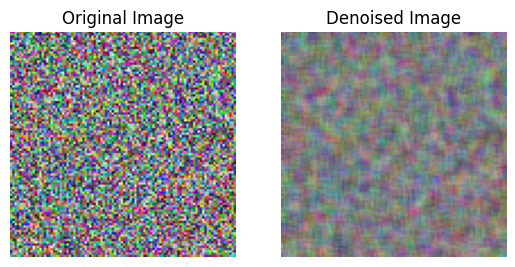

In [42]:

plt.subplot(1, 2, 1)
plt.imshow(noisy_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(denoised_image, cmap='gray')
plt.title('Denoised Image')
plt.axis('off')

plt.show()


# Test on Dog Image

(-0.5, 299.5, 286.5, -0.5)

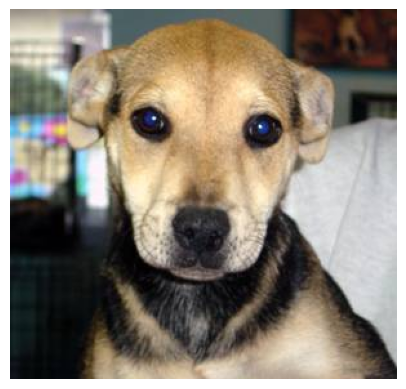

In [43]:
image = Image.open('./data/dogs/dog.4.jpg')

image_array = np.array(image)
plt.imshow(image_array)
plt.axis('off')



In [44]:
def add_gaussian_noise(image, mean=0, sigma=45):
    h, w, c = image.shape
    noise = np.random.normal(mean, sigma, (h, w, c))
    noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)
    return noisy_image

(-0.5, 299.5, 286.5, -0.5)

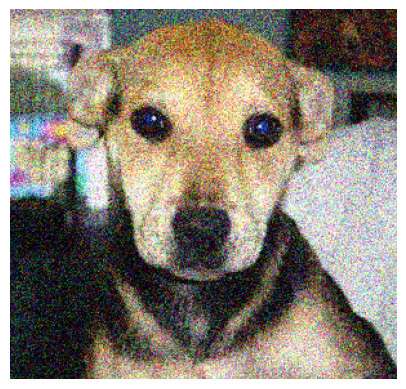

In [45]:
noisy_image = add_gaussian_noise(image_array)
plt.imshow(noisy_image)
plt.axis('off')

# Compare

C:\Users\austi\AppData\Local\Temp\ipykernel_5624\653036244.py:30: RuntimeWarning: overflow encountered in scalar negative
  return np.exp(-p_dist(image, p1_center, p2_center, p_size) / (h ** 2)) # Smaller distances -> higher weight assigned to p2


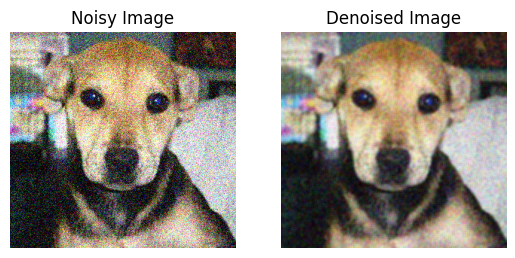

In [46]:
denoised = denoise_image(noisy_image, h = 30000)

plt.subplot(1, 2, 1)
plt.imshow(noisy_image)
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(denoised)
plt.title('Denoised Image')
plt.axis('off')

plt.show()


# Denoise All Attacked Images Through Framework

In [47]:
import os

In [48]:
def denoise_folder(folder_path, h, limit=100000):
    '''
    Denoise up to a specified number of images in a folder and save them while recreating the subfolder structure
    within the topmost "bird-data" directory.

    folder_path: Path to the folder containing images.
    h: Strength parameter for denoising.
    limit: Maximum number of images to denoise.
    '''
    output_base_folder = os.path.join(os.path.dirname(os.path.dirname(folder_path)), 'denoised')
    os.makedirs(output_base_folder, exist_ok=True)

    count = 0
    for root, _, files in os.walk(folder_path):
        # Create subfolder structure under denoised folder
        output_folder = os.path.join(output_base_folder, os.path.relpath(root, folder_path))
        os.makedirs(output_folder, exist_ok=True)

        for file in files:
            if file.endswith('.jpg'):
                image_path = os.path.join(root, file)
                image = np.array(Image.open(image_path))
                denoised_image = denoise_image(image, h)
                denoised_image = Image.fromarray(denoised_image.astype(np.uint8))
                output_path = os.path.join(output_folder, file)
                denoised_image.save(output_path)
                count += 1
                if count >= limit:
                    return  # Exit the function if the limit is reached

In [49]:
denoise_folder("bird-data/adv_images_25/bird-data/test", h = 30000)

C:\Users\austi\AppData\Local\Temp\ipykernel_5624\653036244.py:30: RuntimeWarning: overflow encountered in scalar negative
  return np.exp(-p_dist(image, p1_center, p2_center, p_size) / (h ** 2)) # Smaller distances -> higher weight assigned to p2
